In [1]:
#Loading necessary libraries
library('pacman')
p_load(dplyr,purrr,twitteR,wordcloud,tidytext,tm,ggplot2)

Warning message:
"package 'pacman' was built under R version 3.6.3"

In [2]:
#Setting global options with an authenticated app
consumerKey = "YOUR API CONUSMER KEY"  
consumerSecret = "YOUR API CONSUMER SECRET"
accessToken = "YOUR API ACCESS TOKEN"
accessSecret = "YOUR API ACCESS SECRET"
options(httr_oauth_cache=TRUE)
setup_twitter_oauth(consumer_key = consumerKey, consumer_secret = consumerSecret,
                    access_token = accessToken, access_secret = accessSecret)

[1] "Using direct authentication"


In [3]:
#As an example I'll request Ricardo Fort tweets, an entertainment idol who passed away and has become an internet sensation.
#Maximum quantity of requested tweets is 3200
fort_tweets <- userTimeline("ricarfort", n = 3200)
#Converting tweets to tibble format using map_df function
fort_tweets_df<-as_tibble(map_df(fort_tweets,as.data.frame))

In [4]:
#Inspecting
head(fort_tweets_df)

text,favorited,favoriteCount,replyToSN,created,truncated,replyToSID,id,replyToUID,statusSource,screenName,retweetCount,isRetweet,retweeted,longitude,latitude
Gracias por los mensajes. Saludos a todos desde Miami https://t.co/BVo4nHJRJf,TRUE,9198,NA,2021-08-07 16:50:57,FALSE,NA,1424050439591444483,NA,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",ricarfort,170,FALSE,FALSE,NA,NA
Hola! Somos Marta y Felipe. Desde hoy vamos a mantener esta cuenta activa en homenaje a papá. Empezamos dándoles es… https://t.co/z7nOgzp4md,TRUE,63651,NA,2021-08-06 15:45:53,TRUE,NA,1423671678744334338,NA,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",ricarfort,4571,FALSE,TRUE,NA,NA
JONATHAN GONZALEZ - MO DIGAS NADA http://t.co/CZoNu8qnrg,FALSE,1646,NA,2013-11-22 12:19:57,FALSE,NA,403860402192142337,NA,"<a href=""http://www.apple.com"" rel=""nofollow"">iOS</a>",ricarfort,510,FALSE,FALSE,NA,NA
SOLO UNA TARADA IGNORANTE PUEDE TIRAR UNA ESTUPIDES. ASO,FALSE,15896,NA,2013-11-22 11:10:47,FALSE,NA,403842994379706368,NA,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",ricarfort,28966,FALSE,FALSE,NA,NA
NO PUEDO CREER LA MEDICA QUE ESTA CON MAURO VIALE LO PELOTUDA E IGNORARNTE QUE ES...,FALSE,2468,NA,2013-11-22 11:07:45,FALSE,NA,403842232827916288,NA,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",ricarfort,1396,FALSE,FALSE,NA,NA
QUE VAYAN TODOS LO MÉDICOS A LA PUERTA DE AMÉRICA PARA CONTAR TODOS LOS MEDICAMENTOS QUE ESTE HOMBRE PROHIBIÓ ENTRAR!!!!!!!!!,FALSE,1779,NA,2013-11-21 01:46:45,FALSE,NA,403338661594275841,NA,"<a href=""http://twitter.com/download/iphone"" rel=""nofollow"">Twitter for iPhone</a>",ricarfort,1977,FALSE,FALSE,NA,NA


In [5]:
#Deleting columns that don't agree useful information
tweets<-subset(fort_tweets_df,select=-c(favorited,isRetweet,retweeted,replyToSN,truncated,replyToSID,id,replyToUID,statusSource,longitude,latitude))
head(tweets)

text,favoriteCount,created,screenName,retweetCount
Gracias por los mensajes. Saludos a todos desde Miami https://t.co/BVo4nHJRJf,9198,2021-08-07 16:50:57,ricarfort,170
Hola! Somos Marta y Felipe. Desde hoy vamos a mantener esta cuenta activa en homenaje a papá. Empezamos dándoles es… https://t.co/z7nOgzp4md,63651,2021-08-06 15:45:53,ricarfort,4571
JONATHAN GONZALEZ - MO DIGAS NADA http://t.co/CZoNu8qnrg,1646,2013-11-22 12:19:57,ricarfort,510
SOLO UNA TARADA IGNORANTE PUEDE TIRAR UNA ESTUPIDES. ASO,15896,2013-11-22 11:10:47,ricarfort,28966
NO PUEDO CREER LA MEDICA QUE ESTA CON MAURO VIALE LO PELOTUDA E IGNORARNTE QUE ES...,2468,2013-11-22 11:07:45,ricarfort,1396
QUE VAYAN TODOS LO MÉDICOS A LA PUERTA DE AMÉRICA PARA CONTAR TODOS LOS MEDICAMENTOS QUE ESTE HOMBRE PROHIBIÓ ENTRAR!!!!!!!!!,1779,2013-11-21 01:46:45,ricarfort,1977


In [6]:
#Inspecting the tibble
summary(tweets)

     text           favoriteCount        created                   
 Length:1497        Min.   :    0.0   Min.   :2013-04-04 23:59:36  
 Class :character   1st Qu.:    1.0   1st Qu.:2013-06-24 01:17:45  
 Mode  :character   Median :    7.0   Median :2013-08-20 17:20:47  
                    Mean   :  265.6   Mean   :2013-08-14 22:18:49  
                    3rd Qu.:   26.0   3rd Qu.:2013-09-24 03:59:48  
                    Max.   :63651.0   Max.   :2021-08-07 16:50:57  
  screenName         retweetCount  
 Length:1497        Min.   :    0  
 Class :character   1st Qu.:    2  
 Mode  :character   Median :    7  
                    Mean   :  376  
                    3rd Qu.:   22  
                    Max.   :97625  

In [8]:
#Separating words in tweets
tweet_words <- tweets %>% select( text) %>% unnest_tokens(word,text)

In [9]:
#Removing special characters
tweet_words <- gsub("[[:cntrl:]]", " ", tweet_words)

In [10]:
#Converting to lowercase
tweet_words <- tolower(tweet_words)

In [11]:
#Applying removeWords with stopwords("spanish") to eliminate empty words
tweet_words <- removeWords(tweet_words, words = stopwords("spanish"))

In [12]:
#Removing punctuation
tweet_words <- removePunctuation(tweet_words)

In [13]:
#Finally we eliminate the excessive empty spaces, many of them introduced by the previous transformations.
tweet_words <- stripWhitespace(tweet_words)

Warning message in tm_map.SimpleCorpus(corpus, tm::removePunctuation):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, function(x) tm::removeWords(x, tm::stopwords())):
"transformation drops documents"

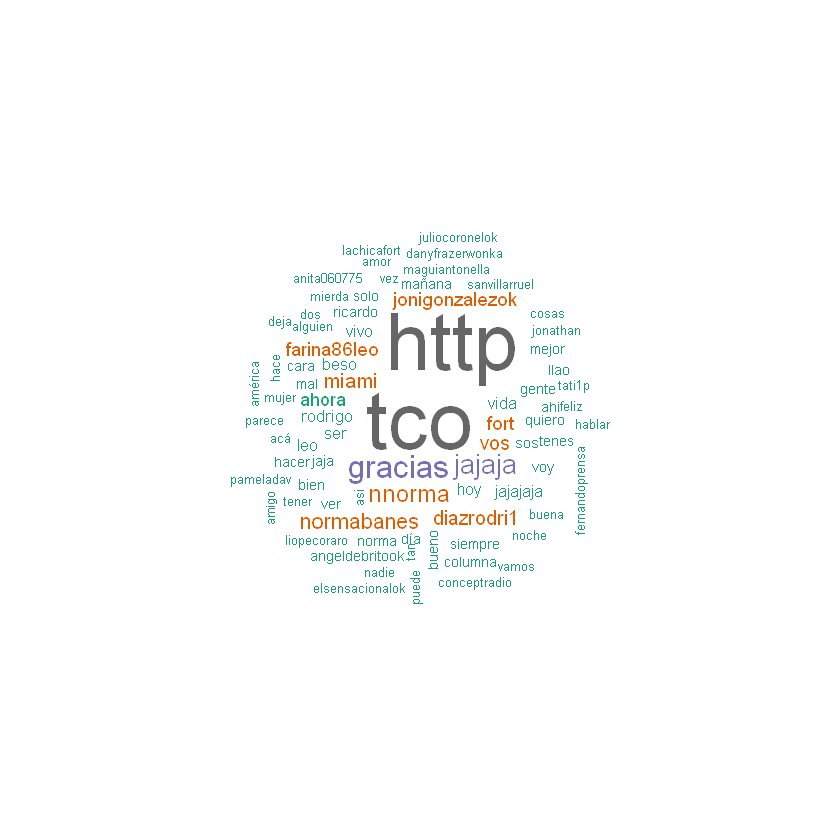

In [14]:
#Creating the wordcloud using the namesake
wordcloud(tweet_words, max.words = 80, random.order = F, colors = brewer.pal(name = "Dark2", n = 8))

In [15]:
#improving the wordcloud removing useless words
tweet_words <- removeWords(tweet_words, words = c("leofariok","adrianpalla","amaliegranata","karijelinek",
                                                  "jona","fabioeltano","maguiantonella","llao","sanvillarruel",
                                                  "tati1p","fernandoprensa","karinajelinek","lachicafort",
                                                  "juliocoronelok","angeldebritook","elsensacionalok","anita060775",
                                                  "liopecoraro","natachajaitt","danyfrazerwonka","pameladav","http",
                                                  "tco", "nnorma", "farina86leo", "normabanes", "diazrodri1",
                                                  "jonigonzalezok"))

Warning message in tm_map.SimpleCorpus(corpus, tm::removePunctuation):
"transformation drops documents"Warning message in tm_map.SimpleCorpus(corpus, function(x) tm::removeWords(x, tm::stopwords())):
"transformation drops documents"

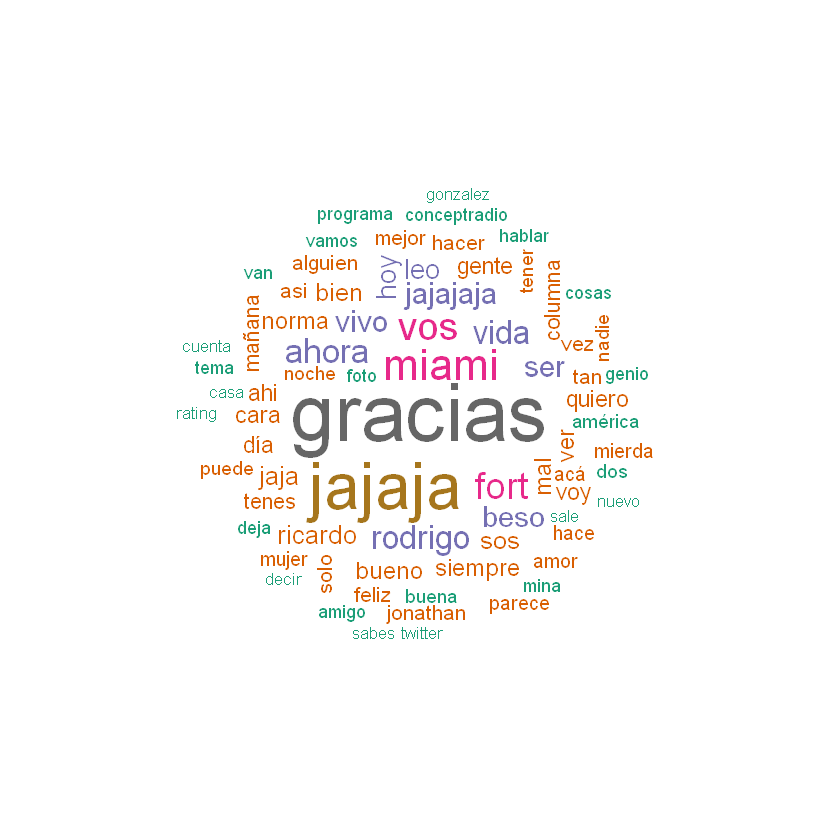

In [16]:
wordcloud(tweet_words, max.words = 75, random.order = F, colors = brewer.pal(name = "Dark2", n = 8))

## Term document Matrix

In [18]:
# Converting words to corpus so it is easier to make operations with the words.
tweet_corpus <- tweet_words %>% VectorSource() %>% Corpus()
tweet_corpus

<<SimpleCorpus>>
Metadata:  corpus specific: 1, document level (indexed): 0
Content:  documents: 1

In [19]:
# We will use the TermDocumentMatrix function in our Corpus and assign the result to the tweet_tdm object. 

tweet_tdm <- TermDocumentMatrix(tweet_corpus)
tweet_tdm

<<TermDocumentMatrix (terms: 3913, documents: 1)>>
Non-/sparse entries: 3913/0
Sparsity           : 0%
Maximal term length: 29
Weighting          : term frequency (tf)

In [22]:
#Although a word cloud visually shows us the frequency of words in our Corpus, it does not return quantities.
#To obtain them, I will first transform our tweets_tdm object into an object of class matrix, which again will have a number
#of lines equal to the number of different words in our Corpus and number of columns equal to the number of documents.

tweet_mat <- as.matrix(tweet_tdm)
dim(tweet_mat)

[1] 3913    1

In [23]:
#We obtain the row sums (rowSums) ordered from highest to lowest (sort with decreasing = TRUE) to know the 
#frequency of each word and then we transform the results to a data.frame class object with two columns, word and freq, 
#which will allow us to easily graph the content.

tweet_mat <- tweet_mat %>% rowSums() %>% sort(decreasing = TRUE)

In [29]:
# Convert to data.frame

tweet_mat <- data.frame(palabra = names(tweet_mat), frec = tweet_mat,row.names=NULL)
head(tweet_mat)

ERROR: Error in data.frame(palabra = names(tweet_mat), frec = tweet_mat, row.names = NULL): arguments imply differing number of rows: 2, 3913


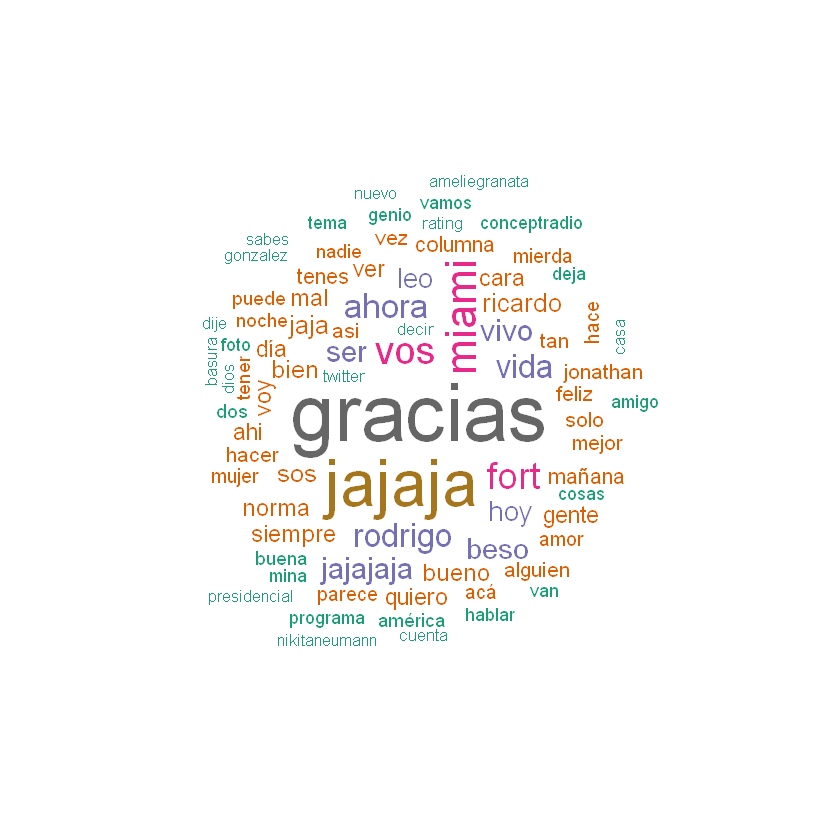

In [31]:
# With this object it is also possible to create a wordcloud, using different arguments.

wordcloud(
  words = tweet_mat$palabra, 
  freq = tweet_mat$frec, 
  max.words = 80, 
  random.order = F, 
  colors=brewer.pal(name = "Dark2", n = 8)
  )

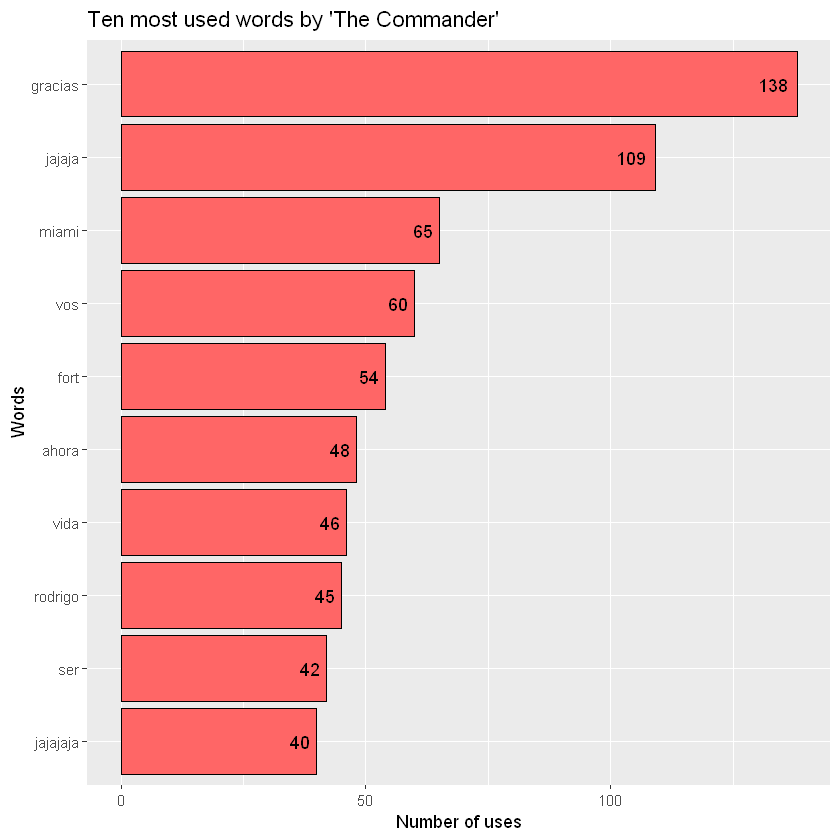

In [32]:
# Barplot of the most used words

tweet_mat[1:10, ] %>%
  ggplot(aes(x = reorder(palabra, frec), y = frec)) +
  geom_bar(stat = "identity", color = "black", fill = "#FF6666") +
  geom_text(aes(hjust = 1.3, label = frec)) + 
  coord_flip() + 
  labs(title = "Ten most used words by 'The Commander'",  x = "Words", y = "Number of uses")

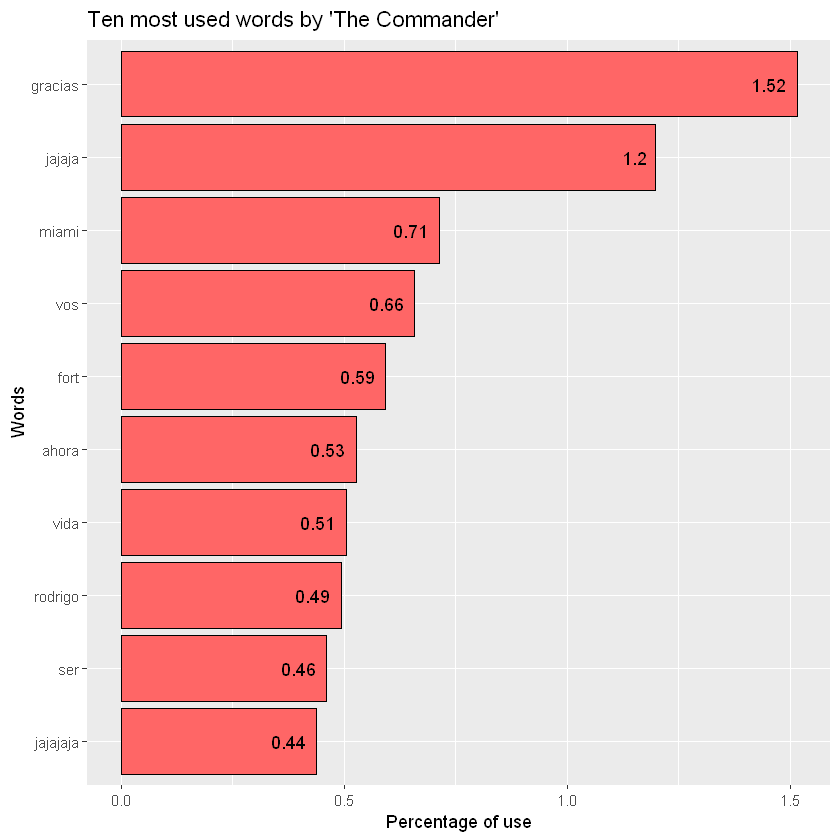

In [33]:
tweet_mat %>%
  mutate(perc = (frec/sum(frec))*100) %>%
  .[1:10, ] %>%
  ggplot(aes(x = reorder(palabra, perc), y = perc)) +
  geom_bar(stat = "identity", color = "black", fill = "#FF6666") +
  geom_text(aes(hjust = 1.3, label = round(perc, 2))) + 
  coord_flip() +
 labs(title = "Ten most used words by 'The Commander'",  x = "Words", y = "Percentage of use")